In [1]:
import preamble

In [2]:
import torch

VOCABULARY = {
    'adverb': [
        'slightly',
        'greatly',
        'smoothly',
        'sharply',
        'slowly',
        'quickly',
        'lightly',
        'significantly',
        'softly',
        'harshly',
        'gradually',
        'immediately',
    ],
    'direction': {
        'X': {
            'left': [
                'left',
                'leftward',
                'to the left'
            ],
            
            'right': [
                'right',
                'rightward',
                'to the right',
            ],
        },
        'Y': {
            'forward': [
                'forward',
                'ahead',
                'to the front',
            ],
            'backward': [
                'backward',
                'behind',
                'to the back',
            ],
        },
        'Z': {
            'up': [
                'up',
                'upward',
                'above',
            ],
            'down': [
                'down',
                'downward',
                'below',
            ],
        },
    },
}

CARTESIAN_AXES = set(VOCABULARY['direction'].keys())
CARTESIAN_DIRECTIONS = {direction for axes_directions in VOCABULARY['direction'].values() for direction in axes_directions.keys()}
CARTESIAN_DIRECTION_TO_AXIS = {direction: axis for axis, axis_directions in VOCABULARY['direction'].items() for direction in axis_directions.keys()}
DIRECTION_PART_TO_AXIS = {direction_part: axis for axis, axis_directions in VOCABULARY['direction'].items() for direction_parts in axis_directions.values() for direction_part in direction_parts}
DIRECTION_PART_TO_CARTESIAN_DIRECTION = {direction_part: direction for axis_directions in VOCABULARY['direction'].values() for direction, direction_parts in axis_directions.items() for direction_part in direction_parts}

ADVERBS = sorted(VOCABULARY['adverb'] + [''])

CARTESIAN_DIRECTIONS = sorted(list(CARTESIAN_DIRECTIONS) + [''])

print(ADVERBS)
print(CARTESIAN_DIRECTIONS)

def encode_phrase(adverb, first_cartesian_direction, second_carteisian_direction):
    def one_hot_encode(value, categories):
        one_hot_vector = torch.zeros(len(categories))
        if value in categories:
            one_hot_vector[categories.index(value)] = 1
        else:
            raise ValueError(f'value {value} not in categories {categories}')
        return one_hot_vector

    while adverb not in ADVERBS:
        adverb = input(f"Invalid adverb '{adverb}'. Please enter a valid adverb: ")

    while first_cartesian_direction not in CARTESIAN_DIRECTIONS:
        first_cartesian_direction = input(f"Invalid direction '{first_cartesian_direction}'. Please enter a valid direction: ")

    while second_carteisian_direction not in CARTESIAN_DIRECTIONS:
        second_carteisian_direction = input(f"Invalid direction '{second_carteisian_direction}'. Please enter a valid direction: ")

    adverb_one_hot = one_hot_encode(adverb, ADVERBS)
    first_direction_one_hot = one_hot_encode(first_cartesian_direction, CARTESIAN_DIRECTIONS)
    second_direction_one_hot = one_hot_encode(second_carteisian_direction, CARTESIAN_DIRECTIONS)

    phrase_one_hot = torch.cat((adverb_one_hot, first_direction_one_hot, second_direction_one_hot))

    return phrase_one_hot, adverb_one_hot, first_direction_one_hot, second_direction_one_hot

def decode_phrase(phrase_vector):
    """
    Decodes a binary vector into a human-readable phrase.

    Args:
        phrase_vector (torch.Tensor): A binary vector representing the phrase.

    Returns:
        str: The decoded human-readable phrase.
    """
    # Split the vector into adverb, first direction, and second direction
    adverb_vector = phrase_vector[:len(ADVERBS)]
    first_direction_vector = phrase_vector[len(ADVERBS):len(ADVERBS) + len(CARTESIAN_DIRECTIONS)]
    second_direction_vector = phrase_vector[len(ADVERBS) + len(CARTESIAN_DIRECTIONS):]

    # Find the active indices
    adverb = ADVERBS[adverb_vector.argmax()] if adverb_vector.sum() > 0 else ''
    first_direction = CARTESIAN_DIRECTIONS[first_direction_vector.argmax()] if first_direction_vector.sum() > 0 else ''
    second_direction = CARTESIAN_DIRECTIONS[second_direction_vector.argmax()] if second_direction_vector.sum() > 0 else ''

    # Construct the phrase
    return f'{adverb} {first_direction} {second_direction}'.strip()

['', 'gradually', 'greatly', 'harshly', 'immediately', 'lightly', 'quickly', 'sharply', 'significantly', 'slightly', 'slowly', 'smoothly', 'softly']
['', 'backward', 'down', 'forward', 'left', 'right', 'up']


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultimodalAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(MultimodalAutoencoder, self).__init__()

        # Force encoder and decoder
        self.force_encoder = nn.Sequential(
            nn.Flatten(start_dim=1),  # Automatically flatten (batch_size, 4, 256) -> (batch_size, 1024)
            nn.Linear(4 * 256, 512),  # Flattened force input -> 512
            nn.ReLU(),
            nn.Linear(512, latent_dim)  # Compress to latent_dim
        )
        self.force_decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),  # Expand from latent_dim
            nn.ReLU(),
            nn.Linear(512, 4 * 256),  # Reconstruct flattened force tensor
            nn.Unflatten(1, (4, 256))  # Reshape back to (batch_size, 4, 256)
        )

        # Phrase encoder and decoder
        self.phrase_encoder = nn.Sequential(
            nn.Linear(27, 128),  # Phrase binary vector (27 dims) -> 128
            nn.ReLU(),
            nn.Linear(128, latent_dim)  # Compress to latent_dim
        )
        self.phrase_decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Expand from latent_dim
            nn.ReLU(),
            nn.Linear(128, 27)  # Output logits for all 27 dimensions
        )

    def encode_force(self, force):
        return self.force_encoder(force)

    def encode_phrase(self, phrase):
        return self.phrase_encoder(phrase)

    def decode_force(self, latent):
        return self.force_decoder(latent)

    def decode_phrase(self, latent):
        """
        Decode the latent vector into 27 logits (3 segments).
        Apply softmax independently to each of the 3 segments.
        """
        logits = self.phrase_decoder(latent)

        # Split logits into 3 segments
        adverb_logits = logits[:, :len(ADVERBS)]  # Adverbs segment
        first_direction_logits = logits[:, len(ADVERBS):len(ADVERBS) + len(CARTESIAN_DIRECTIONS)]  # First direction
        second_direction_logits = logits[:, len(ADVERBS) + len(CARTESIAN_DIRECTIONS):]  # Second direction

        # Apply softmax to each segment
        adverb_probs = F.softmax(adverb_logits, dim=1)
        first_direction_probs = F.softmax(first_direction_logits, dim=1)
        second_direction_probs = F.softmax(second_direction_logits, dim=1)

        # Concatenate probabilities to form the final output
        return torch.cat((adverb_probs, first_direction_probs, second_direction_probs), dim=1)

    def forward(self, force, phrase):
        # Encode both modalities
        force_latent = self.encode_force(force)
        phrase_latent = self.encode_phrase(phrase)

        # Decode into both modalities
        force_reconstructed = self.decode_force(force_latent)
        phrase_reconstructed = self.decode_phrase(phrase_latent)

        # Cross-reconstruct each modality
        force_cross_reconstructed = self.decode_force(phrase_latent)
        phrase_cross_reconstructed = self.decode_phrase(force_latent)

        return (force_latent, phrase_latent,
                force_reconstructed, phrase_reconstructed,
                force_cross_reconstructed, phrase_cross_reconstructed)

In [4]:
def compute_phrase_loss(reconstructed_phrase, target_phrase):
    """
    Computes cross-entropy loss for each segment of the phrase vector.

    Args:
        reconstructed_phrase: Tensor of shape (batch_size, 27), containing softmax outputs.
        target_phrase: Tensor of shape (batch_size, 27), containing one-hot labels.

    Returns:
        Total loss for all three segments.
    """
    # Split reconstructed phrase into 3 segments
    adverb_logits = reconstructed_phrase[:, :len(ADVERBS)]
    first_direction_logits = reconstructed_phrase[:, len(ADVERBS):len(ADVERBS) + len(CARTESIAN_DIRECTIONS)]
    second_direction_logits = reconstructed_phrase[:, len(ADVERBS) + len(CARTESIAN_DIRECTIONS):]

    # Split target phrase into 3 segments
    adverb_target = target_phrase[:, :len(ADVERBS)].argmax(dim=1)  # Convert one-hot to class indices
    first_direction_target = target_phrase[:, len(ADVERBS):len(ADVERBS) + len(CARTESIAN_DIRECTIONS)].argmax(dim=1)
    second_direction_target = target_phrase[:, len(ADVERBS) + len(CARTESIAN_DIRECTIONS):].argmax(dim=1)

    # Compute cross-entropy loss for each segment
    adverb_loss = F.cross_entropy(adverb_logits, adverb_target)
    first_direction_loss = F.cross_entropy(first_direction_logits, first_direction_target)
    second_direction_loss = F.cross_entropy(second_direction_logits, second_direction_target)

    # Total loss
    total_loss = adverb_loss + first_direction_loss + second_direction_loss
    return total_loss

def train_multimodal_autoencoder(model, dataloader, epochs=20, lr=0.001, device='mps'):
    """
    Trains the multimodal autoencoder with alignment, reconstruction, and cross-reconstruction losses.

    Args:
        model: MultimodalAutoencoder model.
        dataloader: DataLoader providing (force, phrase) pairs.
        epochs: Number of training epochs.
        lr: Learning rate.
        device: Device to train on (e.g., 'mps' or 'cpu').
    """
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Move model to device
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in dataloader:
            # Load inputs
            force, phrase = batch
            force = force.to(device)
            phrase = phrase.to(device)

            # Forward pass
            (force_latent, phrase_latent,
             force_reconstructed, phrase_reconstructed,
             force_cross_reconstructed, phrase_cross_reconstructed) = model(force, phrase)

            # Compute losses
            # 1. Alignment loss: Align force and phrase latent spaces
            alignment_loss = F.mse_loss(force_latent, phrase_latent)

            # 2. Phrase reconstruction loss
            phrase_reconstruction_loss = compute_phrase_loss(phrase_reconstructed, phrase)

            # 3. Force reconstruction loss
            force_reconstruction_loss = F.mse_loss(force_reconstructed, force)

            # 4. Cross-reconstruction losses
            #    a. Force to Phrase
            force_to_phrase_loss = compute_phrase_loss(phrase_cross_reconstructed, phrase)

            #    b. Phrase to Force
            phrase_to_force_loss = F.mse_loss(force_cross_reconstructed, force)

            # Total loss
            total_loss = (alignment_loss +
                          phrase_reconstruction_loss +
                          force_reconstruction_loss +
                          force_to_phrase_loss +
                          phrase_to_force_loss)

            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        # Log epoch loss
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.6f}")

In [5]:
from multimodal_pairs import MultimodalPairsDataset, MultimodalPairsSampler
from torch.utils.data import DataLoader

# Define dataset directory
data_dir = "../data/global_standardized_and_absolute_time_channel_multimodal_pairs"

# Initialize dataset
dataset = MultimodalPairsDataset(data_dir)

# Define sampler with custom probabilities for no_action pairs
no_action_prob = 0  # Adjust probability for sampling 'no_action' pairs
num_samples_per_epoch = 420  # Total number of samples per epoch (optional)

sampler = MultimodalPairsSampler(
    dataset=dataset,
    no_action_prob=no_action_prob,
    num_samples_per_epoch=num_samples_per_epoch
)

# Create DataLoader
batch_size = 420  # Define batch size
dataloader = DataLoader(
    dataset=dataset,
    sampler=sampler,
    batch_size=batch_size
)

In [6]:
# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = MultimodalAutoencoder(latent_dim=16)

# Train the model
train_multimodal_autoencoder(model, dataloader, epochs=2000, lr=0.001, device=device)

/Users/kv/Documents/School/shared-language-force-embedding/src/multimodal_pairs.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  multimodal_pair = torch.load(file_path)


Epoch [1/2000], Total Loss: 15.058224
Epoch [2/2000], Total Loss: 15.273350
Epoch [3/2000], Total Loss: 15.003965
Epoch [4/2000], Total Loss: 14.831490
Epoch [5/2000], Total Loss: 14.756869
Epoch [6/2000], Total Loss: 14.833958
Epoch [7/2000], Total Loss: 14.792480
Epoch [8/2000], Total Loss: 14.950326
Epoch [9/2000], Total Loss: 14.837721
Epoch [10/2000], Total Loss: 14.687798
Epoch [11/2000], Total Loss: 14.730802
Epoch [12/2000], Total Loss: 14.555400
Epoch [13/2000], Total Loss: 14.603481
Epoch [14/2000], Total Loss: 14.444176
Epoch [15/2000], Total Loss: 14.480765
Epoch [16/2000], Total Loss: 14.308913
Epoch [17/2000], Total Loss: 14.286466
Epoch [18/2000], Total Loss: 14.346135
Epoch [19/2000], Total Loss: 14.353547
Epoch [20/2000], Total Loss: 14.031893
Epoch [21/2000], Total Loss: 13.960752
Epoch [22/2000], Total Loss: 13.875301
Epoch [23/2000], Total Loss: 14.206277
Epoch [24/2000], Total Loss: 13.886480
Epoch [25/2000], Total Loss: 13.862786
Epoch [26/2000], Total Loss: 13.89

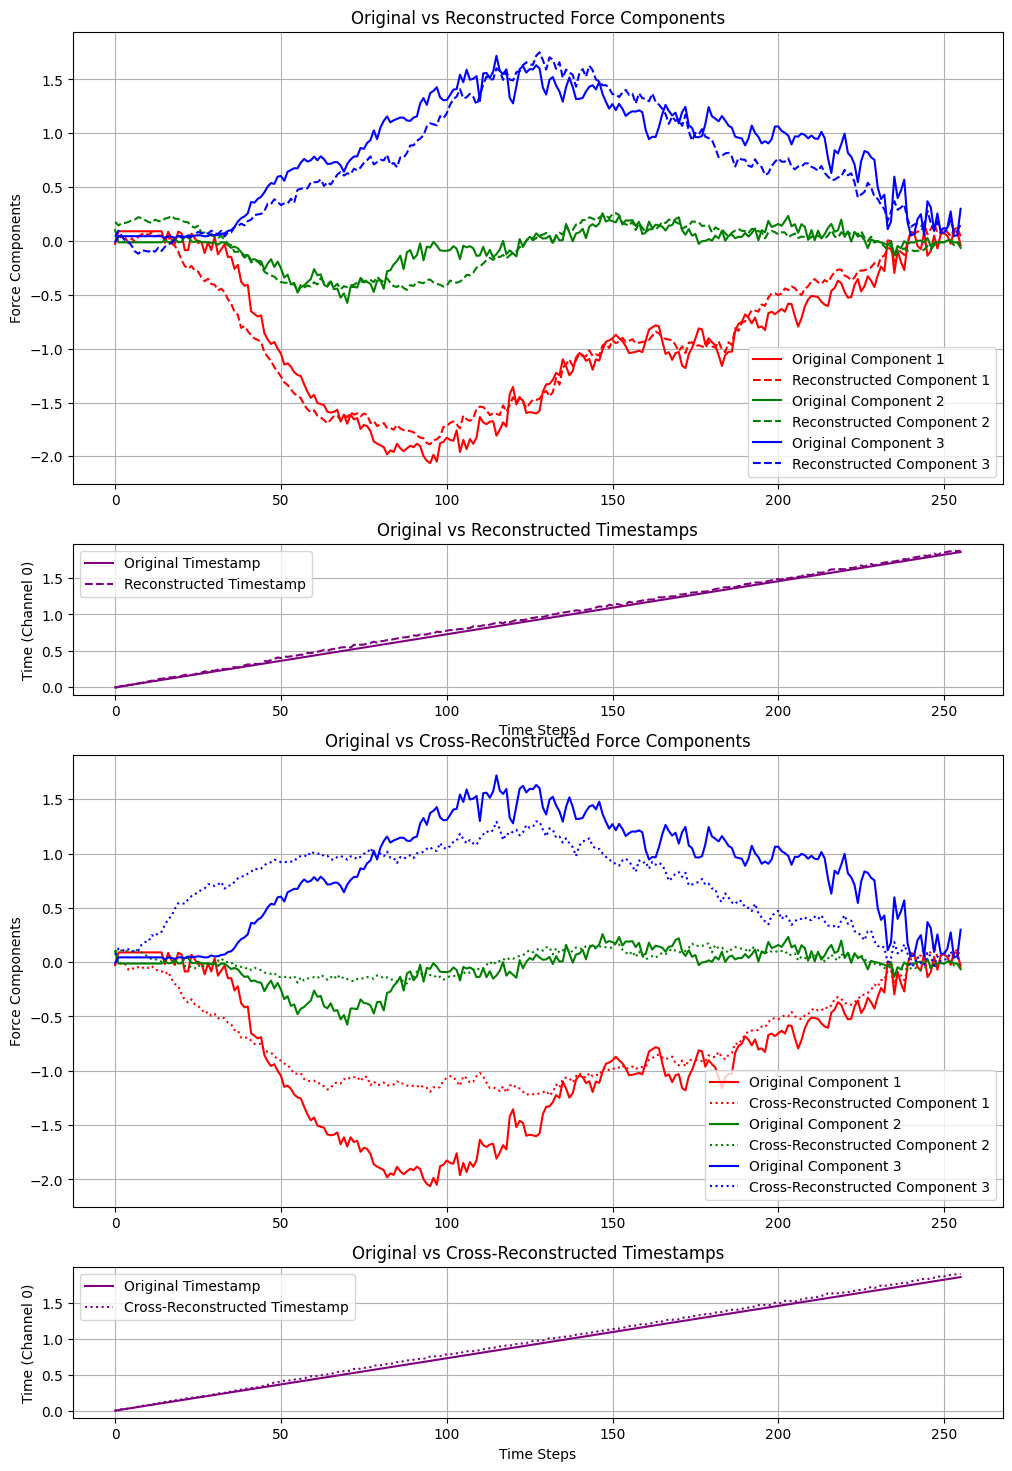

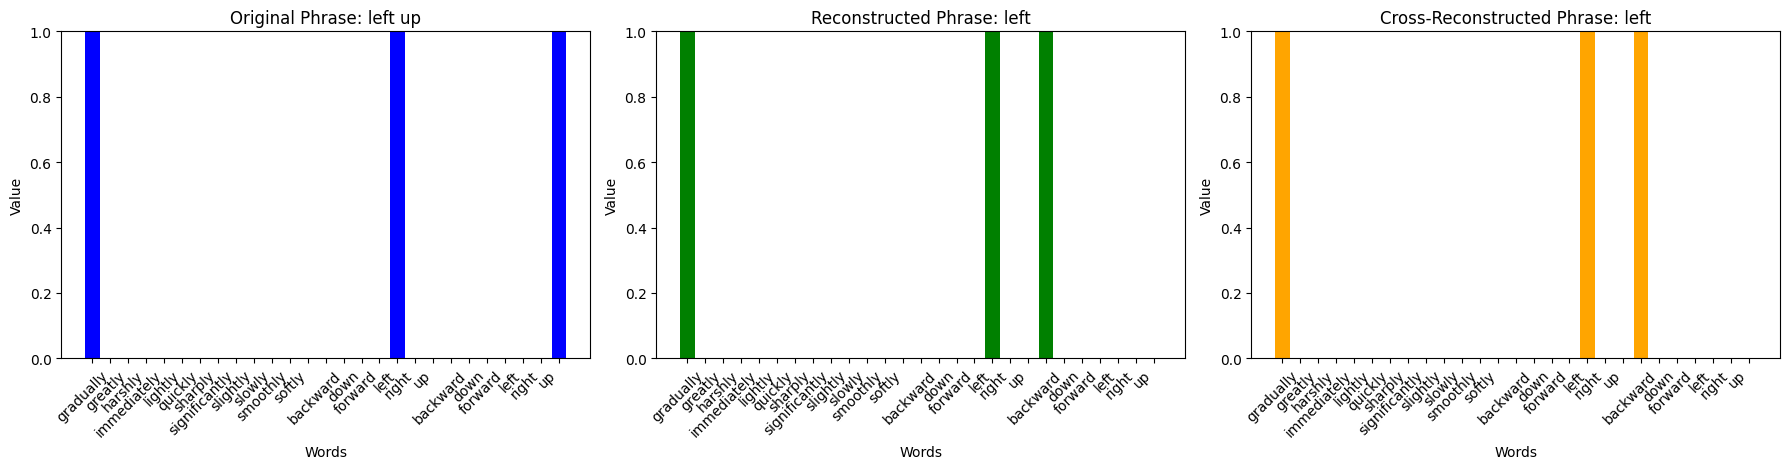

Original Phrase:
Text: left up
Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1.]

Reconstructed Phrase:
Text: left
Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0.]

Cross-Reconstructed Phrase:
Text: left
Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0.]


In [43]:
import matplotlib.pyplot as plt
import random
import numpy as np

def plot_reconstructed_force(model, dataset, no_action_prob=0.5):
    """
    Plots the original and reconstructed force tensor, and prints phrase vectors and decoded text.

    Args:
        model: Trained multimodal autoencoder model.
        dataset: The dataset containing multimodal pairs.
        no_action_prob (float): Probability of selecting a no_action pair (default=0.5).
    """
    # Separate indices into action and no_action
    action_indices = [i for i, path in enumerate(dataset.file_paths) if "no_action" not in path]
    no_action_indices = [i for i, path in enumerate(dataset.file_paths) if "no_action" in path]

    # Sample based on probability
    if random.random() < no_action_prob:
        idx = random.choice(no_action_indices)  # Sample no_action pair
    else:
        idx = random.choice(action_indices)  # Sample action pair

    # Load the selected sample
    force_tensor, original_phrase_vector = dataset[idx]  # Original data
    force_tensor = force_tensor.unsqueeze(0).to(device)  # Add batch dim for model input
    original_phrase_vector = original_phrase_vector.unsqueeze(0).to(device)

    # Pass through the model
    model.eval()
    with torch.no_grad():
        # Forward pass to get all reconstructed and cross-reconstructed outputs
        (force_latent, phrase_latent,
         force_reconstructed, phrase_reconstructed,
         force_cross_reconstructed, phrase_cross_reconstructed) = model(force_tensor, original_phrase_vector)

        force_reconstructed = force_reconstructed.squeeze(0).cpu()
        phrase_reconstructed = phrase_reconstructed.squeeze(0).cpu()
        force_cross_reconstructed = force_cross_reconstructed.squeeze(0).cpu()
        phrase_cross_reconstructed = phrase_cross_reconstructed.squeeze(0).cpu()

    # Decode phrases
    original_phrase = decode_phrase(original_phrase_vector.squeeze(0).cpu())
    reconstructed_phrase = decode_phrase((phrase_reconstructed).float())  # Thresholded
    cross_reconstructed_phrase = decode_phrase((phrase_cross_reconstructed).float())  # Thresholded

    # Plot original and reconstructed forces
    time_steps = range(force_tensor.shape[2])  # Assuming length 256

    # Create subplots: force components, timestamps, and cross-reconstructed outputs
    fig, axs = plt.subplots(4, 1, figsize=(12, 18), gridspec_kw={'height_ratios': [3, 1, 3, 1]})

    # ----- Plot Force Components (1, 2, 3) -----
    colors = ['r', 'g', 'b']  # Colors for components 1, 2, 3
    for i in range(1, 4):  # Channels 1, 2, 3
        axs[0].plot(time_steps, force_tensor[0, i].cpu().numpy(), label=f'Original Component {i}', color=colors[i-1])
        axs[0].plot(time_steps, force_reconstructed[i].numpy(), label=f'Reconstructed Component {i}', color=colors[i-1], linestyle='--')

    axs[0].set_ylabel('Force Components')
    axs[0].set_title('Original vs Reconstructed Force Components')
    axs[0].legend()
    axs[0].grid(True)

    # ----- Plot Timestamps (0th Channel) -----
    axs[1].plot(time_steps, force_tensor[0, 0].cpu().numpy(), label='Original Timestamp', color='purple')
    axs[1].plot(time_steps, force_reconstructed[0].numpy(), label='Reconstructed Timestamp', color='purple', linestyle='--')

    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Time (Channel 0)')
    axs[1].set_title('Original vs Reconstructed Timestamps')
    axs[1].legend()
    axs[1].grid(True)

    # ----- Plot Cross-Reconstructed Force (1, 2, 3) -----
    for i in range(1, 4):  # Channels 1, 2, 3
        axs[2].plot(time_steps, force_tensor[0, i].cpu().numpy(), label=f'Original Component {i}', color=colors[i-1])
        axs[2].plot(time_steps, force_cross_reconstructed[i].numpy(), label=f'Cross-Reconstructed Component {i}', color=colors[i-1], linestyle=':')

    axs[2].set_ylabel('Force Components')
    axs[2].set_title('Original vs Cross-Reconstructed Force Components')
    axs[2].legend()
    axs[2].grid(True)

    # ----- Plot Cross-Reconstructed Timestamps (0th Channel) -----
    axs[3].plot(time_steps, force_tensor[0, 0].cpu().numpy(), label='Original Timestamp', color='purple')
    axs[3].plot(time_steps, force_cross_reconstructed[0].numpy(), label='Cross-Reconstructed Timestamp', color='purple', linestyle=':')

    axs[3].set_xlabel('Time Steps')
    axs[3].set_ylabel('Time (Channel 0)')
    axs[3].set_title('Original vs Cross-Reconstructed Timestamps')
    axs[3].legend()
    axs[3].grid(True)

    # Convert phrase vectors to NumPy arrays for visualization
    original_phrase_vector = original_phrase_vector.squeeze(0).cpu().numpy()
    phrase_reconstructed = phrase_reconstructed.cpu().numpy()  # Ensure tensor is on CPU
    phrase_cross_reconstructed = phrase_cross_reconstructed.cpu().numpy()  # Ensure tensor is on CPU

    # Create a separate figure for phrase vectors
    fig_phrases, phrase_axs = plt.subplots(1, 3, figsize=(18, 6))

    # Get the labels (words) for the phrase vector
    word_labels = ADVERBS + CARTESIAN_DIRECTIONS + CARTESIAN_DIRECTIONS  # Assuming these are your vocabulary lists

    # ----- Original Phrase Vector -----
    phrase_axs[0].bar(np.arange(len(original_phrase_vector)), original_phrase_vector, color='blue')
    phrase_axs[0].set_title(f"Original Phrase: {original_phrase}")
    phrase_axs[0].set_ylim(0, 1)
    phrase_axs[0].set_xlabel('Words')
    phrase_axs[0].set_ylabel('Value')
    phrase_axs[0].set_xticks(np.arange(len(word_labels)))  # Set ticks at each word index
    phrase_axs[0].set_xticklabels(word_labels, rotation=45, ha='right')  # Rotate labels for spacing

    # ----- Reconstructed Phrase Vector -----
    phrase_axs[1].bar(np.arange(len(phrase_reconstructed)), phrase_reconstructed, color='green')
    phrase_axs[1].set_title(f"Reconstructed Phrase: {reconstructed_phrase}")
    phrase_axs[1].set_ylim(0, 1)
    phrase_axs[1].set_xlabel('Words')
    phrase_axs[1].set_ylabel('Value')
    phrase_axs[1].set_xticks(np.arange(len(word_labels)))
    phrase_axs[1].set_xticklabels(word_labels, rotation=45, ha='right')

    # ----- Cross-Reconstructed Phrase Vector -----
    phrase_axs[2].bar(np.arange(len(phrase_cross_reconstructed)), phrase_cross_reconstructed, color='orange')
    phrase_axs[2].set_title(f"Cross-Reconstructed Phrase: {cross_reconstructed_phrase}")
    phrase_axs[2].set_ylim(0, 1)
    phrase_axs[2].set_xlabel('Words')
    phrase_axs[2].set_ylabel('Value')
    phrase_axs[2].set_xticks(np.arange(len(word_labels)))
    phrase_axs[2].set_xticklabels(word_labels, rotation=45, ha='right')

    # Adjust layout and display
    plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust layout
    plt.show()

    # Print out phrase texts and raw vectors
    print("Original Phrase:")
    print(f"Text: {original_phrase}")
    print(f"Vector: {np.round(original_phrase_vector)}")

    print("\nReconstructed Phrase:")
    print(f"Text: {reconstructed_phrase}")
    print(f"Vector: {np.round(phrase_reconstructed)}")

    print("\nCross-Reconstructed Phrase:")
    print(f"Text: {cross_reconstructed_phrase}")
    print(f"Vector: {np.round(phrase_cross_reconstructed)}")

# Example usage
plot_reconstructed_force(model, dataset, no_action_prob=sampler.no_action_prob)

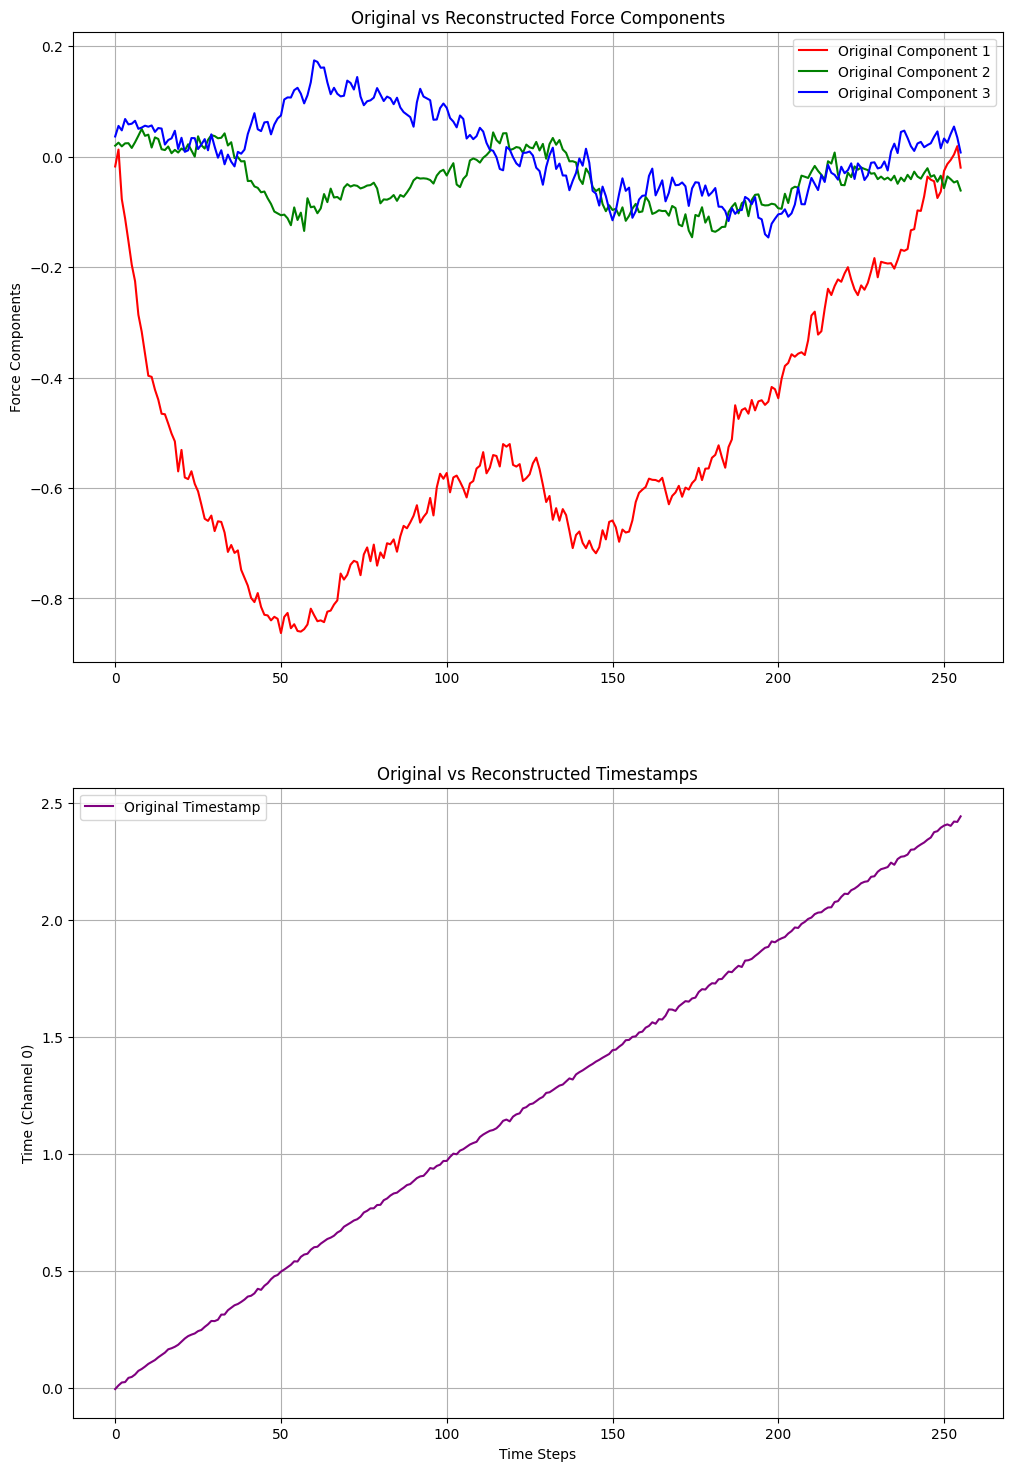

In [41]:
p, _, _, _ = encode_phrase('smoothly', 'left', '')
model.eval()
with torch.no_grad():
    l = model.encode_phrase(p.to(device))[None, :]
    f = model.decode_force(l)

# Plot original and reconstructed forces
time_steps = range(f.shape[2])  # Assuming length 256

# Create subplots: force components, timestamps, and cross-reconstructed outputs
fig, axs = plt.subplots(2, 1, figsize=(12, 18))

# ----- Plot Force Components (1, 2, 3) -----
colors = ['r', 'g', 'b']  # Colors for components 1, 2, 3
for i in range(1, 4):  # Channels 1, 2, 3
    axs[0].plot(time_steps, f[0, i].cpu().numpy(), label=f'Original Component {i}', color=colors[i-1])

axs[0].set_ylabel('Force Components')
axs[0].set_title('Original vs Reconstructed Force Components')
axs[0].legend()
axs[0].grid(True)

# ----- Plot Timestamps (0th Channel) -----
axs[1].plot(time_steps, f[0, 0].cpu().numpy(), label='Original Timestamp', color='purple')

axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Time (Channel 0)')
axs[1].set_title('Original vs Reconstructed Timestamps')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [40]:
# torch.save(model.state_dict(), '../models/first_attempt.pt')